# Sage Shaw

### ME 571 - Spring 2018

# HW 1 - Problem 2 - Median of Medians

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd

from random import shuffle
from itertools import repeat

In [2]:
#quick select functions
def select_split(lst):
    assert len(lst)>0
    if len(lst)==1: return lst[0]
    pivot = lst[0]
    left = [l for l in lst[1:] if l<pivot]
    right = [l for l in lst[1:] if pivot<l]
    return left, pivot, right
''' Reaching recursion limit
def quick_select(lst, rank):
    if len(lst)==1: return lst[0]
    left, pivot, right = select_split(lst)
    l = len(left)
    if l==rank:
        return pivot
    elif len(left)<rank:
        return quick_select(right, rank - (l+1))
    else:
        return quick_select(left, rank)
'''

# Non-recursive version
def quick_select(lst, rank):
    l = 0
    while l >= 0:
        if len(lst)==1: return lst[0]
        left, pivot, right = select_split(lst)
        l = len(left)
        if l == rank:
            return pivot
        elif l < rank:
            lst = right
            rank -= l+1
        else:
            lst = left
    
#MoM functions

def my_map(arg):
    return quick_select(arg[0],arg[1])

def my_partition(arg):
    lst, MoM = arg
    left = [x for x in lst if x<=MoM]
    right = [x for x in lst if x>MoM]
    return left, right
    
    
def MoM(lst, p):
    #print(lst)
    rank = len(lst)//2 - 1
    #print('starting rank of %d' % rank)
    my_list = lst
    pool = mp.Pool(p)
    
    while len(my_list)>p**2 and len(my_list)>2*p:
        child_ranks = len(my_list)//(p*2)
        sublists = [my_list[i::p] for i in range(p)]
        #children find medians
        meds = pool.map(my_map, zip(sublists, repeat(child_ranks)))
        #calculate MoM
        #print('MoM turn')
        MoM = quick_select(meds, p//2)
        #print(MoM)
        #children partition lists and return them
        partitions = pool.map(my_partition, zip(sublists, repeat(MoM)), )       
        #print(partitions)
        #MoM counts and discards side
        count = sum([len(left) for left, right in partitions])
        if count >= rank:
            my_list = [x for left, right in partitions for x in left]
        else:
            my_list = [x for left, right in partitions for x in right]
            rank -= count
        #print(my_list)
        #print(rank)
    pool.close()
    pool.join()
        
    return quick_select(my_list, rank)


In [3]:
'''
A = list(range(10**6))
print('shuffle')
#shuffle(A)
print('MoM')
MoM(A, 16)
'''

"\nA = list(range(10**6))\nprint('shuffle')\n#shuffle(A)\nprint('MoM')\nMoM(A, 16)\n"

In [4]:
def stats_from_timeit(timeit_result, num_proc, description):
    t = timeit_result.best
    data_row = {'Time': t, 'Processors': num_proc}
    return pd.Series(data=data_row, name=description)

In [5]:
N = 10**7
lst = list(range(N))
shuffle(lst)

columns = ['Time', 'Processors', 'Speed-Up', 'Efficiency', 'Theoretical Speed-Up', 'Theoretical Efficiency']
median_data = pd.DataFrame(columns=columns)

In [6]:
#process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in range(6)]

#my_time = %timeit -o w = quick_select(lst, len(lst)//2)
#T0 = my_time.best
#median_data = median_data.append(stats_from_timeit(my_time, 1, 'Serial'))

for p in process_counts:
    my_time = %timeit -o w = MoM(lst, p)
    if p==1: T0 = my_time.best
    median_data = median_data.append(stats_from_timeit(my_time, p, 'Parallel'))

1 loop, best of 3: 24.3 s per loop
1 loop, best of 3: 16.2 s per loop
1 loop, best of 3: 12.3 s per loop
1 loop, best of 3: 11.2 s per loop
1 loop, best of 3: 11.3 s per loop
1 loop, best of 3: 12.3 s per loop


In [7]:
median_data['Speed-Up'] = T0/median_data['Time']
median_data['Efficiency'] = median_data['Speed-Up']/median_data['Processors']
median_data['Theoretical Speed-Up'] = median_data['Processors']
median_data['Theoretical Efficiency'] = 1
median_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Parallel,24.250555,1.0,1.000000,1.000000,1.0,1
Parallel,16.228655,2.0,1.494305,0.747152,2.0,1
Parallel,12.341375,4.0,1.964980,0.491245,4.0,1
Parallel,11.241395,8.0,2.157255,0.269657,8.0,1
Parallel,11.276676,16.0,2.150506,0.134407,16.0,1
Parallel,12.253120,32.0,1.979133,0.061848,32.0,1


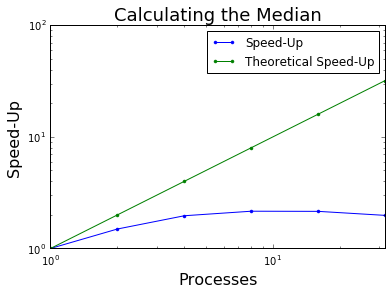

In [8]:
parallel_data = median_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Median',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

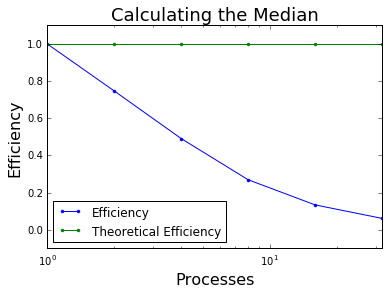

In [9]:
parallel_data = median_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Median",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

# Analysis

Whew!!! Fourth time's the charm I suppose.

The code all works except that for lists that are too big I reach the recursion limit. This can be solved by using a version of Quick Sort that is non-recursive. It is interesting to note that since the work is divided up among the processes, this can be fixed by using enough processes. This is of course a terrible way to avoid a recursion limit, but I found it an interesting side-effect. In the end I modified my Quick Select to run in a loop.

I was very surprised that this program actually shows speed-up! The earlier parallelized algorithms in this problem (problem 2) experienced little to no speed-up. I believe this is because the serialized Quick Sort is roughly as memory intensive as the MoM algorith. The Sum/Mean/SD functions required very little, so the overhead of chuncking the lists was significant. While this was true for the MoM algorithm, it is also true for the serialized Quick Select and thus there are still savings when parallelizing.